In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time
import os
from scipy.stats import norm
import scipy.optimize as optimize


In [2]:
# Set random seed to ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [4]:
# Heston model parameters
class HestonParams:
    def __init__(self):
        self.S0 = 100.0       # Initial stock price
        self.V0 = 0.04        # Initial volatility
        self.kappa = 2.0      # Mean reversion speed of volatility
        self.theta = 0.04     # Long-term mean of volatility
        self.sigma = 0.3      # Volatility of volatility
        self.rho = -0.7       # Correlation between price and volatility
        self.r = 0.05         # Risk-free rate
        self.T = 1.0          # Option maturity (years)
        self.K = 100.0        # Option strike price
        self.trading_days = 252  # Trading days per year


In [5]:
# Simulate Heston model
def simulate_heston(params, n_paths, n_steps):
    dt = params.T / n_steps
    sqrt_dt = np.sqrt(dt)
    
    # Initialize paths
    S = np.zeros((n_paths, n_steps + 1))
    V = np.zeros((n_paths, n_steps + 1))
    integrated_var = np.zeros((n_paths, n_steps + 1))
    
    # Set initial values
    S[:, 0] = params.S0
    V[:, 0] = params.V0
    
    # Generate correlated random numbers using PyTorch
    Z1 = torch.randn(n_paths, n_steps).numpy()
    Z2 = params.rho * Z1 + np.sqrt(1 - params.rho**2) * torch.randn(n_paths, n_steps).numpy()
    
    # Simulate paths
    for t in range(n_steps):
        # Ensure volatility is positive
        V[:, t] = np.maximum(V[:, t], 0)
        
        # Update stock price
        S[:, t+1] = S[:, t] * np.exp((params.r - 0.5 * V[:, t]) * dt + np.sqrt(V[:, t]) * sqrt_dt * Z1[:, t])
        
        # Update volatility
        V[:, t+1] = V[:, t] + params.kappa * (params.theta - V[:, t]) * dt + params.sigma * np.sqrt(V[:, t]) * sqrt_dt * Z2[:, t]
        
        # Calculate integrated variance
        integrated_var[:, t+1] = integrated_var[:, t] + V[:, t] * dt
    
    return S, V, integrated_var


In [6]:
# Calculate European put option payoff
def put_option_payoff(S, K):
    if isinstance(S, torch.Tensor):
        return torch.maximum(torch.tensor(K, device=S.device) - S, torch.tensor(0.0, device=S.device))
    else:
        return np.maximum(K - S, 0)


In [7]:
# Calculate variance swap value based on formula (31)
def calculate_variance_swap(integrated_var_t, V_t, t, T, params):
    """
    Calculate variance swap value based on S_t^2 = ∫_0^t V_s ds + L(t, V_t)
    where L(t,v) = (v-h)/α * (1-e^(-α(T-t))) + h(T-t)
    
    Parameters:
    integrated_var_t - Realized variance from 0 to t
    V_t - Current instantaneous variance
    t - Current time
    T - Maturity
    params - Model parameters
    
    Returns:
    variance_swap_value - Variance swap value
    """
    # Calculate L(t, V_t) term
    h = params.theta      # Long-term variance mean
    alpha = params.kappa  # Mean reversion rate
    
    remaining_T = T - t
    L_t_v = (V_t - h) / alpha * (1 - np.exp(-alpha * remaining_T)) + h * remaining_T
    
    # Variance swap value = realized variance + expected future variance
    variance_swap_value = integrated_var_t + L_t_v
    
    return variance_swap_value


In [8]:
# Calculate sensitivity of variance swap to instantaneous variance
def variance_swap_sensitivity(V_t, t, T, params):
    """
    Calculate ∂L(t,V_t)/∂V_t for hedging purposes
    
    Parameters:
    V_t - Current instantaneous variance
    t - Current time
    T - Maturity
    params - Model parameters
    
    Returns:
    sensitivity - Partial derivative of L with respect to V
    """
    alpha = params.kappa
    remaining_T = T - t
    
    # From the formula: ∂L(t,v)/∂v = 1/α * (1-e^(-α(T-t)))
    sensitivity = (1 - np.exp(-alpha * remaining_T)) / alpha
    
    return sensitivity


In [9]:
# Deep Hedging model - using PyTorch's nn.Module
class DeepHedgingModel(nn.Module):
    def __init__(self, n_features, hidden_dim=64):
        super(DeepHedgingModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 2)
        )
        
        # Use proper initialization methods
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)


In [10]:
# Calculate VaR according to traditional definition (positive value)
def compute_var(portfolio_values, alpha=0.05):
    """
    Calculate Value at Risk (VaR) as a positive value
    
    VaR_alpha(X) = inf{m | P(X < -m) <= alpha}
    
    Parameters:
    portfolio_values - Portfolio P&L values (positive = profit, negative = loss)
    alpha - Confidence level (e.g., 0.05 for 95% confidence)
    
    Returns:
    VaR as a positive value
    """
    # Sort portfolio values in ascending order
    sorted_values, _ = torch.sort(portfolio_values)
    
    # Determine threshold index
    n = sorted_values.size(0)
    alpha_index = int(torch.ceil(torch.tensor(alpha * n))) - 1
    alpha_index = torch.max(torch.tensor(0), torch.tensor(alpha_index))
    
    # Get the value at the threshold index 
    var_value = sorted_values[alpha_index]
    
    # VaR is the negative of this value (to make losses positive)
    # but if var_value is positive (profit), VaR should be 0
    return torch.max(torch.tensor(0.0, device=portfolio_values.device), -var_value)


In [11]:
# Calculate CVaR (Expected Shortfall) - revised to be positive for losses
def compute_cvar(portfolio_values, alpha=0.05):
    """
    Calculate Conditional Value at Risk (CVaR) as a positive value
    
    CVaR_alpha(X) = 1/alpha * E[X | X <= -VaR_alpha(X)]
    
    Parameters:
    portfolio_values - Portfolio P&L values (positive = profit, negative = loss)
    alpha - Confidence level (e.g., 0.05 for 95% confidence)
    
    Returns:
    CVaR as a positive value
    """
    # Sort portfolio values in ascending order
    sorted_values, _ = torch.sort(portfolio_values)
    
    # Determine threshold index
    n = sorted_values.size(0)
    alpha_index = int(torch.ceil(torch.tensor(alpha * n)))
    alpha_index = torch.max(torch.tensor(1), torch.tensor(alpha_index))
    
    # Extract values below threshold
    tail_values = sorted_values[:alpha_index]
    
    # Calculate CVaR as the negative of the mean (to make losses positive)
    # If mean is positive (average profit in worst cases), CVaR should be 0
    return torch.max(torch.tensor(0.0, device=portfolio_values.device), -torch.mean(tail_values))


In [12]:
# Calculate trading costs
def calculate_trading_cost(trades, cost_factor=0.001):
    # Calculate cost of each trade, proportional to the trade volume
    return cost_factor * torch.sum(torch.abs(trades))


In [13]:
# Train model with increased epochs (100 epochs)
def train_deep_hedging_model(model, params, n_paths, n_steps, epochs=100, batch_size=64, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Updated scheduler for longer training - less aggressive reduction and longer patience
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.7, verbose=True)
    
    # For tracking training progress
    loss_history = []
    val_loss_history = []  # Track validation loss
    best_loss = float('inf')
    best_model_state = None
    model.train()
    
    # Generate fixed validation set (10% of n_paths)
    val_size = int(0.1 * n_paths)
    S_val, V_val, integrated_var_val = simulate_heston(params, val_size, n_steps)
    option_payoff_val = put_option_payoff(S_val[:, -1], params.K)
    
    start_total_time = time.time()
    for epoch in range(epochs):
        start_time = time.time()
        
        # Generate new paths for training
        S, V, integrated_var = simulate_heston(params, n_paths, n_steps)
        
        # Calculate option payoffs
        option_payoff_np = put_option_payoff(S[:, -1], params.K)
        
        # Divide data into batches
        n_batches = n_paths // batch_size
        epoch_loss = 0
        
        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = (batch + 1) * batch_size
            
            # Initialize portfolio value and positions
            portfolio_values = torch.zeros(batch_size, device=device)
            stock_position = torch.zeros(batch_size, device=device)
            var_swap_position = torch.zeros(batch_size, device=device)
            total_cost = torch.tensor(0.0, device=device)
            
            optimizer.zero_grad()
            
            for t in range(n_steps):
                curr_t = t * params.T / n_steps
                remaining_T = params.T - curr_t
                
                # Current state (price, volatility, time, etc.)
                features = torch.cat([
                    torch.tensor(S[start_idx:end_idx, t], dtype=torch.float32).view(batch_size, 1),
                    torch.tensor(V[start_idx:end_idx, t], dtype=torch.float32).view(batch_size, 1),
                    torch.tensor(integrated_var[start_idx:end_idx, t], dtype=torch.float32).view(batch_size, 1),
                    torch.ones(batch_size, 1) * t / n_steps
                ], dim=1).to(device)
                
                # Predict new trade volumes
                trades = model(features)
                stock_trades = trades[:, 0]
                var_swap_trades = trades[:, 1]
                
                # Calculate trading costs
                step_cost = calculate_trading_cost(trades)
                total_cost += step_cost
                
                # Update positions
                stock_position += stock_trades
                var_swap_position += var_swap_trades
                
                # Calculate new variance swap values according to formula (31)
                var_swap_t = torch.tensor([
                    calculate_variance_swap(
                        integrated_var[start_idx+i, t], 
                        V[start_idx+i, t], 
                        curr_t, 
                        params.T, 
                        params
                    ) for i in range(batch_size)
                ], dtype=torch.float32, device=device)
                
                var_swap_t_plus_dt = torch.tensor([
                    calculate_variance_swap(
                        integrated_var[start_idx+i, t+1], 
                        V[start_idx+i, t+1], 
                        curr_t + params.T/n_steps, 
                        params.T, 
                        params
                    ) for i in range(batch_size)
                ], dtype=torch.float32, device=device)
                
                # Update portfolio value (including P&L for this time step)
                stock_pnl = stock_position * torch.tensor(S[start_idx:end_idx, t+1] - S[start_idx:end_idx, t], 
                                                         dtype=torch.float32, device=device)
                var_swap_pnl = var_swap_position * (var_swap_t_plus_dt - var_swap_t)
                
                portfolio_values += stock_pnl + var_swap_pnl - step_cost
            
            # Add option payoff, calculate final portfolio value
            option_payoff_batch = torch.tensor(option_payoff_np[start_idx:end_idx], dtype=torch.float32, device=device)
            final_portfolio = portfolio_values - option_payoff_batch
            
            # Calculate CVaR as loss function - now directly minimizing CVaR
            loss = compute_cvar(final_portfolio)  # We minimize CVaR directly (no negative sign)
            
            # Backpropagation and optimization
            loss.backward()
            # Gradient clipping to avoid explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        loss_history.append(avg_loss)
        
        # Validate on fixed validation set
        model.eval()
        with torch.no_grad():
            # Evaluate on validation set
            val_portfolio_values = torch.zeros(val_size, device=device)
            val_stock_position = torch.zeros(val_size, device=device)
            val_var_swap_position = torch.zeros(val_size, device=device)
            val_total_cost = torch.tensor(0.0, device=device)
            
            for t in range(n_steps):
                curr_t = t * params.T / n_steps
                remaining_T = params.T - curr_t
                
                val_features = torch.cat([
                    torch.tensor(S_val[:, t], dtype=torch.float32).view(val_size, 1),
                    torch.tensor(V_val[:, t], dtype=torch.float32).view(val_size, 1),
                    torch.tensor(integrated_var_val[:, t], dtype=torch.float32).view(val_size, 1),
                    torch.ones(val_size, 1) * t / n_steps
                ], dim=1).to(device)
                
                # Process in batches to avoid memory issues
                val_batch_size = 200
                all_trades = []
                
                for i in range(0, val_size, val_batch_size):
                    end_idx = min(i + val_batch_size, val_size)
                    batch_features = val_features[i:end_idx]
                    batch_trades = model(batch_features)
                    all_trades.append(batch_trades)
                
                # Combine results from all batches
                val_trades = torch.cat(all_trades, dim=0)
                val_stock_trades = val_trades[:, 0]
                val_var_swap_trades = val_trades[:, 1]
                
                # Calculate trading costs
                val_step_cost = calculate_trading_cost(val_trades)
                val_total_cost += val_step_cost
                
                # Update positions
                val_stock_position += val_stock_trades
                val_var_swap_position += val_var_swap_trades
                
                # Calculate new variance swap values
                val_var_swap_t = torch.tensor([
                    calculate_variance_swap(
                        integrated_var_val[i, t], 
                        V_val[i, t], 
                        curr_t, 
                        params.T, 
                        params
                    ) for i in range(val_size)
                ], dtype=torch.float32, device=device)
                
                val_var_swap_t_plus_dt = torch.tensor([
                    calculate_variance_swap(
                        integrated_var_val[i, t+1], 
                        V_val[i, t+1], 
                        curr_t + params.T/n_steps, 
                        params.T, 
                        params
                    ) for i in range(val_size)
                ], dtype=torch.float32, device=device)
                
                # Update portfolio value
                val_stock_pnl = val_stock_position * torch.tensor(S_val[:, t+1] - S_val[:, t], 
                                                         dtype=torch.float32, device=device)
                val_var_swap_pnl = val_var_swap_position * (val_var_swap_t_plus_dt - val_var_swap_t)
                
                val_portfolio_values += val_stock_pnl + val_var_swap_pnl - val_step_cost
            
            # Final portfolio value (minus option payoff)
            val_option_payoff = torch.tensor(option_payoff_val, dtype=torch.float32, device=device)
            val_final_portfolio = val_portfolio_values - val_option_payoff
            
            # Calculate validation loss - directly compute CVaR
            val_loss = compute_cvar(val_final_portfolio)
            val_loss_history.append(val_loss.item())
        
        # Back to training mode
        model.train()
        
        # Save best model
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            print(f"Epoch {epoch + 1}: New best model with validation loss: {best_loss:.4f}")
        
        # Use learning rate scheduler
        scheduler.step(val_loss.item())
        
        # Display training progress - more frequent updates for longer training
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Val Loss: {val_loss.item():.4f}, Time: {time.time() - start_time:.2f}s")
            
        # Every 25 epochs, show more detailed progress
        if (epoch + 1) % 25 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            elapsed_time = time.time() - start_total_time
            estimated_total = elapsed_time * (epochs / (epoch + 1))
            estimated_remaining = estimated_total - elapsed_time
            print(f"Progress: {epoch + 1}/{epochs} ({(epoch + 1)/epochs*100:.1f}%)")
            print(f"Current learning rate: {current_lr:.6f}")
            print(f"Time elapsed: {elapsed_time/60:.1f} minutes")
            print(f"Estimated remaining: {estimated_remaining/60:.1f} minutes")
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_loss:.4f}")
    
    # Total training time
    total_training_time = time.time() - start_total_time
    print(f"Total training time: {total_training_time/60:.2f} minutes")
    
    return loss_history, val_loss_history


In [14]:
# Evaluate model
def evaluate_model(model, params, n_paths=1000, n_steps=30):
    model.eval()  # Set to evaluation mode
    print("\nStarting Deep Hedging Model evaluation...")
    
    # Generate new paths for evaluation
    print(f"Generating {n_paths} paths with {n_steps} steps for evaluation...")
    S, V, integrated_var = simulate_heston(params, n_paths, n_steps)
    
    # Calculate option payoffs
    option_payoff_np = put_option_payoff(S[:, -1], params.K)
    
    # Initialize
    portfolio_values = np.zeros(n_paths)
    stock_positions = np.zeros((n_paths, n_steps + 1))
    var_swap_positions = np.zeros((n_paths, n_steps + 1))
    trading_costs = np.zeros(n_paths)
    
    # Set up progress monitoring
    print(f"Running Deep Hedging Model on paths...")
    progress_interval = max(1, n_steps // 5)  # Update every 20% of time steps
    start_time = time.time()
    
    with torch.no_grad():  # Don't calculate gradients during evaluation
        for t in range(n_steps):
            if t % progress_interval == 0 or t == n_steps - 1:
                elapsed = time.time() - start_time
                progress = (t + 1) / n_steps * 100
                print(f"  Progress: {progress:.1f}% - Step {t+1}/{n_steps}, Time: {elapsed:.1f}s")
            
            curr_t = t * params.T / n_steps
            remaining_T = params.T - curr_t
            
            # Feature vectors
            features = torch.cat([
                torch.tensor(S[:, t], dtype=torch.float32).view(n_paths, 1),
                torch.tensor(V[:, t], dtype=torch.float32).view(n_paths, 1),
                torch.tensor(integrated_var[:, t], dtype=torch.float32).view(n_paths, 1),
                torch.ones(n_paths, 1) * t / n_steps
            ], dim=1).to(device)
            
            # Process in batches to avoid memory issues
            batch_size = 200
            all_trades = []
            
            for i in range(0, n_paths, batch_size):
                end_idx = min(i + batch_size, n_paths)
                batch_features = features[i:end_idx]
                batch_trades = model(batch_features)
                all_trades.append(batch_trades)
            
            # Combine results from all batches
            trades = torch.cat(all_trades, dim=0).cpu().numpy()
            stock_trades = trades[:, 0]
            var_swap_trades = trades[:, 1]
            
            # Calculate trading costs
            cost = 0.001 * np.sum(np.abs(trades), axis=1)
            trading_costs += cost
            
            # Update positions
            stock_positions[:, t+1] = stock_positions[:, t] + stock_trades
            var_swap_positions[:, t+1] = var_swap_positions[:, t] + var_swap_trades
            
            # Calculate variance swap values
            var_swap_t = np.array([
                calculate_variance_swap(
                    integrated_var[i, t], 
                    V[i, t], 
                    curr_t, 
                    params.T, 
                    params
                ) for i in range(n_paths)
            ])
            
            var_swap_t_plus_dt = np.array([
                calculate_variance_swap(
                    integrated_var[i, t+1], 
                    V[i, t+1], 
                    curr_t + params.T/n_steps, 
                    params.T, 
                    params
                ) for i in range(n_paths)
            ])
            
            # Update portfolio value
            stock_pnl = stock_positions[:, t+1] * (S[:, t+1] - S[:, t])
            var_swap_pnl = var_swap_positions[:, t+1] * (var_swap_t_plus_dt - var_swap_t)
            
            portfolio_values += stock_pnl + var_swap_pnl - cost
    
    # Final portfolio value (minus option payoff)
    final_portfolio = portfolio_values - option_payoff_np
    
    # Calculate statistics
    mean_pnl = np.mean(final_portfolio)
    std_pnl = np.std(final_portfolio)
    
    # Calculate VaR and CVaR - correctly as positive values for losses
    alpha = 0.05
    sorted_pnl = np.sort(final_portfolio)
    var_index = int(np.ceil(alpha * n_paths)) - 1
    var_index = max(0, var_index)
    var = max(0, -sorted_pnl[var_index])
    cvar = max(0, -np.mean(sorted_pnl[:var_index+1]))
    
    total_time = time.time() - start_time
    print(f"Deep Hedging evaluation completed in {total_time:.2f} seconds")
    print(f"Deep Hedging Evaluation Results:")
    print(f"Mean P&L: {mean_pnl:.4f}")
    print(f"P&L Standard Deviation: {std_pnl:.4f}")
    print(f"VaR(95%): {var:.4f}")
    print(f"CVaR(95%): {cvar:.4f}")
    print(f"Average Trading Cost: {np.mean(trading_costs):.4f}")
    
    return final_portfolio, stock_positions, var_swap_positions


In [15]:
# Heston option pricing and hedging functions

# Heston model characteristic function
def heston_characteristic_function(phi, S, V, T, params):
    a = params.kappa * params.theta
    b = params.kappa
    
    d = np.sqrt((params.rho * params.sigma * phi * 1j - b)**2 + (params.sigma**2) * (phi * 1j + phi**2))
    g = (b - params.rho * params.sigma * phi * 1j - d) / (b - params.rho * params.sigma * phi * 1j + d)
    
    exp1 = np.exp(params.r * T * phi * 1j)
    exp2 = np.exp(a * params.T * (b - params.rho * params.sigma * phi * 1j - d) / (params.sigma**2))
    exp3 = np.exp((V * (b - params.rho * params.sigma * phi * 1j - d)) / (params.sigma**2 * (1 - g * np.exp(-d * T))))
    
    return exp1 * exp2 * exp3


In [16]:
# Calculate option price under Heston model using numerical methods
def heston_option_price_fft(S, V, K, T, params, option_type='put'):
    import numpy as np
    from scipy.integrate import quad
    from scipy import interpolate
    
    # Characteristic function integral
    def integrand_call(phi, S, V, K, T, params):
        numerator = np.exp(-phi * np.log(K) * 1j) * heston_characteristic_function(phi - 1j, S, V, T, params)
        denominator = phi * 1j
        return np.real(numerator / denominator)
    
    # Calculate integral
    result, _ = quad(integrand_call, 0, 100, args=(S, V, K, T, params), limit=100)
    call_price = S / 2 + result / np.pi
    
    # Use put-call parity to get put option price
    if option_type.lower() == 'call':
        return call_price
    else:  # Put option
        return call_price - S + K * np.exp(-params.r * T)


In [17]:
# Calculate option Delta under Heston model
def heston_option_delta(S, V, K, T, params, option_type='put'):
    h = 0.01  # Small price change for numerical differentiation
    
    price_up = heston_option_price_fft(S + h, V, K, T, params, option_type)
    price_down = heston_option_price_fft(S - h, V, K, T, params, option_type)
    
    delta = (price_up - price_down) / (2 * h)
    return delta


In [18]:
# Calculate option Vega (sensitivity to variance) under Heston model
def heston_option_vega(S, V, K, T, params, option_type='put'):
    h = 0.0001  # Small variance change for numerical differentiation
    
    price_up = heston_option_price_fft(S, V + h, K, T, params, option_type)
    price_down = heston_option_price_fft(S, V - h, K, T, params, option_type)
    
    vega = (price_up - price_down) / (2 * h)
    return vega


In [19]:
# Evaluate Delta-Vega hedging strategy based on Formulas (32) and (33)
def evaluate_delta_vega_hedging(params, n_paths=1000, n_steps=30, use_vega=True):
    """
    Evaluate Delta-Vega hedging strategy under Heston model using formula (33)
    δ¹ := ∂u(t,S¹,Vt)/∂S¹ and δ² := ∂u(t,S¹,Vt)/∂L(t,Vt)
    
    Parameters:
    params: Heston model parameters
    n_paths: Number of simulation paths
    n_steps: Number of hedging steps
    use_vega: Whether to use Vega hedging (if False, only Delta hedging)
    
    Returns:
    final_portfolio: Final portfolio values
    delta_positions: Delta hedging positions
    vega_positions: Vega hedging positions
    """
    strategy_name = "Delta-Vega Hedging" if use_vega else "Delta-Only Hedging"
    print(f"\nStarting {strategy_name} evaluation...")
    
    # Generate price paths
    print("Generating price paths...")
    S, V, integrated_var = simulate_heston(params, n_paths, n_steps)
    dt = params.T / n_steps
    
    # Initialize portfolio and positions
    portfolio_values = np.zeros(n_paths)
    delta_positions = np.zeros((n_paths, n_steps + 1))
    vega_positions = np.zeros((n_paths, n_steps + 1))
    trading_costs = np.zeros(n_paths)
    
    # Calculate option payoffs
    option_payoff_np = put_option_payoff(S[:, -1], params.K)
    
    # Set up progress monitoring
    print(f"Starting hedging calculations for {n_paths} paths over {n_steps} steps...")
    total_calculations = n_steps * n_paths
    progress_interval = max(1, n_paths // 10)
    last_progress_time = time.time()
    start_time = time.time()
    
    # Hedge at each time step
    for t in range(n_steps):
        curr_t = t * params.T / n_steps
        remaining_T = params.T - curr_t
        
        print(f"Time step {t+1}/{n_steps} - Remaining T: {remaining_T:.4f}")
        paths_done = 0
        
        # Process each path
        for i in range(n_paths):
            # Calculate Delta (Formula 33: δ¹ := ∂u(t,S¹,Vt)/∂S¹)
            delta = heston_option_delta(S[i, t], V[i, t], params.K, remaining_T, params, 'put')
            delta_trade = -delta - delta_positions[i, t]  # New position minus old position
            delta_positions[i, t+1] = -delta  # Negative delta for hedge
            
            # If using Vega hedging
            if use_vega:
                # Calculate option's sensitivity to variance (Formula 33)
                option_dv_sensitivity = heston_option_vega(S[i, t], V[i, t], params.K, remaining_T, params, 'put')
                
                # Calculate sensitivity of variance swap to instantaneous variance (∂L(t,Vt)/∂Vt)
                vs_sensitivity = variance_swap_sensitivity(V[i, t], curr_t, params.T, params)
                
                # Calculate vega hedge ratio according to formula (33): δ² := ∂u(t,S¹,Vt)/∂L(t,Vt)
                # Here we convert from ∂u/∂V to ∂u/∂L using the chain rule: (∂u/∂V) = (∂u/∂L) * (∂L/∂V)
                # So δ² = (∂u/∂V) / (∂L/∂V)
                vega_hedge_ratio = -option_dv_sensitivity / vs_sensitivity if vs_sensitivity != 0 else 0
                
                vega_trade = vega_hedge_ratio - vega_positions[i, t]
                vega_positions[i, t+1] = vega_hedge_ratio
            else:
                vega_trade = 0
                vega_positions[i, t+1] = 0
            
            # Calculate trading costs
            cost = 0.001 * (np.abs(delta_trade) * S[i, t] + np.abs(vega_trade))
            trading_costs[i] += cost
            
            # Calculate variance swap values for current and next time step
            var_swap_t = calculate_variance_swap(
                integrated_var[i, t], V[i, t], curr_t, params.T, params
            )
            
            var_swap_t_plus_dt = calculate_variance_swap(
                integrated_var[i, t+1], V[i, t+1], curr_t + dt, params.T, params
            )
            
            # Calculate PnL
            delta_pnl = delta_positions[i, t] * (S[i, t+1] - S[i, t])
            vega_pnl = vega_positions[i, t] * (var_swap_t_plus_dt - var_swap_t)
            
            # Update portfolio value
            portfolio_values[i] += delta_pnl + vega_pnl - cost
            
            paths_done += 1
            
            # Update progress
            if paths_done % progress_interval == 0 or paths_done == n_paths:
                current_time = time.time()
                elapsed = current_time - start_time
                progress_pct = (t * n_paths + paths_done) / total_calculations * 100
                
                # Only update if at least 1 second has passed since last update
                if current_time - last_progress_time >= 1.0:
                    last_progress_time = current_time
                    
                    # Estimate time remaining
                    if progress_pct > 0:
                        total_estimated_time = elapsed / (progress_pct / 100)
                        remaining_time = total_estimated_time - elapsed
                        
                        print(f"  Progress: {progress_pct:.1f}% - Paths: {paths_done}/{n_paths} in step {t+1}/{n_steps}")
                        print(f"  Elapsed time: {elapsed:.1f}s, Est. remaining: {remaining_time:.1f}s")
    
    # Final portfolio value (minus option payoff)
    final_portfolio = portfolio_values - option_payoff_np
    
    # Calculate statistics
    mean_pnl = np.mean(final_portfolio)
    std_pnl = np.std(final_portfolio)
    
    # Calculate VaR and CVaR
    alpha = 0.05
    sorted_pnl = np.sort(final_portfolio)
    var_index = int(np.ceil(alpha * n_paths)) - 1
    var_index = max(0, var_index)
    var = max(0, -sorted_pnl[var_index])
    cvar = max(0, -np.mean(sorted_pnl[:var_index+1]))
    
    total_time = time.time() - start_time
    print(f"\n{strategy_name} calculation complete in {total_time:.2f} seconds")
    print(f"{strategy_name} Evaluation Results:")
    print(f"Mean P&L: {mean_pnl:.4f}")
    print(f"P&L Standard Deviation: {std_pnl:.4f}")
    print(f"VaR(95%): {var:.4f}")
    print(f"CVaR(95%): {cvar:.4f}")
    print(f"Average Trading Cost: {np.mean(trading_costs):.4f}")
    
    return final_portfolio, delta_positions, vega_positions


In [20]:
# Evaluate BS Delta hedging strategy as a benchmark
def evaluate_bs_delta_hedging(params, n_paths=1000, n_steps=30):
    """
    Evaluate Black-Scholes Delta hedging strategy (assuming Heston model for the real world)
    """
    print("\nStarting Black-Scholes Delta Hedging evaluation...")
    
    # Generate price paths
    print("Generating price paths...")
    S, V, integrated_var = simulate_heston(params, n_paths, n_steps)
    dt = params.T / n_steps
    
    # Initialize portfolio and positions
    portfolio_values = np.zeros(n_paths)
    delta_positions = np.zeros((n_paths, n_steps + 1))
    trading_costs = np.zeros(n_paths)
    
    # Calculate option payoffs
    option_payoff_np = put_option_payoff(S[:, -1], params.K)
    
    # Set up progress monitoring
    print(f"Starting hedging calculations for {n_paths} paths over {n_steps} steps...")
    total_calculations = n_steps * n_paths
    progress_interval = max(1, n_paths // 10)
    last_progress_time = time.time()
    start_time = time.time()
    
    # Hedge at each time step
    for t in range(n_steps):
        remaining_T = params.T - t * dt
        
        print(f"Time step {t+1}/{n_steps} - Remaining T: {remaining_T:.4f}")
        paths_done = 0
        
        for i in range(n_paths):
            # Calculate Delta using Black-Scholes formula (with current implied volatility)
            current_vol = np.sqrt(V[i, t])
            d1 = (np.log(S[i, t] / params.K) + (params.r + 0.5 * current_vol**2) * remaining_T) / (current_vol * np.sqrt(remaining_T))
            bs_delta = norm.cdf(-d1)  # Delta for put option
            
            # Calculate Delta trade
            delta_trade = -bs_delta - delta_positions[i, t]
            delta_positions[i, t+1] = -bs_delta
            
            # Calculate trading costs
            cost = 0.001 * np.abs(delta_trade) * S[i, t]
            trading_costs[i] += cost
            
            # Calculate PnL
            delta_pnl = delta_positions[i, t] * (S[i, t+1] - S[i, t])
            
            # Update portfolio value
            portfolio_values[i] += delta_pnl - cost
            
            paths_done += 1
            
            # Update progress
            if paths_done % progress_interval == 0 or paths_done == n_paths:
                current_time = time.time()
                elapsed = current_time - start_time
                progress_pct = (t * n_paths + paths_done) / total_calculations * 100
                
                # Only update if at least 1 second has passed since last update
                if current_time - last_progress_time >= 1.0:
                    last_progress_time = current_time
                    
                    # Estimate time remaining
                    if progress_pct > 0:
                        total_estimated_time = elapsed / (progress_pct / 100)
                        remaining_time = total_estimated_time - elapsed
                        
                        print(f"  Progress: {progress_pct:.1f}% - Paths: {paths_done}/{n_paths} in step {t+1}/{n_steps}")
                        print(f"  Elapsed time: {elapsed:.1f}s, Est. remaining: {remaining_time:.1f}s")
    
    # Final portfolio value (minus option payoff)
    final_portfolio = portfolio_values - option_payoff_np
    
    # Calculate statistics
    mean_pnl = np.mean(final_portfolio)
    std_pnl = np.std(final_portfolio)
    
    # Calculate VaR and CVaR
    alpha = 0.05
    sorted_pnl = np.sort(final_portfolio)
    var_index = int(np.ceil(alpha * n_paths)) - 1
    var_index = max(0, var_index)
    var = max(0, -sorted_pnl[var_index])
    cvar = max(0, -np.mean(sorted_pnl[:var_index+1]))
    
    total_time = time.time() - start_time
    print(f"\nBlack-Scholes Delta Hedging calculation complete in {total_time:.2f} seconds")
    print(f"Black-Scholes Delta Hedging Evaluation Results:")
    print(f"Mean P&L: {mean_pnl:.4f}")
    print(f"P&L Standard Deviation: {std_pnl:.4f}")
    print(f"VaR(95%): {var:.4f}")
    print(f"CVaR(95%): {cvar:.4f}")
    print(f"Average Trading Cost: {np.mean(trading_costs):.4f}")
    
    return final_portfolio, delta_positions


In [21]:
# Compare different hedging strategies
def compare_hedging_strategies(params, deep_model, n_paths=500, n_steps=30):
    """
    Compare performance of different hedging strategies
    """
    print("\nStarting comparison of different hedging strategies...")
    
    # Generate the same set of paths for fair comparison
    S, V, integrated_var = simulate_heston(params, n_paths, n_steps)
    option_payoff_np = put_option_payoff(S[:, -1], params.K)
    
    # Deep hedging strategy
    print("\nEvaluating Deep Hedging strategy:")
    deep_pnl, deep_stock, deep_var = evaluate_model(deep_model, params, n_paths, n_steps)
    
    # Heston Delta-Vega hedging
    print("\nEvaluating Heston Delta-Vega hedging strategy:")
    dv_pnl, dv_delta, dv_vega = evaluate_delta_vega_hedging(params, n_paths, n_steps, use_vega=True)
    
    # Heston Delta-only hedging
    print("\nEvaluating Heston Delta-only hedging strategy:")
    d_pnl, d_delta, _ = evaluate_delta_vega_hedging(params, n_paths, n_steps, use_vega=False)
    
    # Black-Scholes Delta hedging
    print("\nEvaluating Black-Scholes Delta hedging strategy:")
    bs_pnl, bs_delta = evaluate_bs_delta_hedging(params, n_paths, n_steps)
    
    # Plot comparison results
    plt.figure(figsize=(15, 12))
    
    # Plot P&L distribution comparison
    plt.subplot(2, 2, 1)
    plt.hist(deep_pnl, bins=30, alpha=0.5, label='Deep Hedging')
    plt.hist(dv_pnl, bins=30, alpha=0.5, label='Heston Delta-Vega')
    plt.hist(d_pnl, bins=30, alpha=0.5, label='Heston Delta')
    plt.hist(bs_pnl, bins=30, alpha=0.5, label='Black-Scholes Delta')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('P&L Distribution Comparison Across Strategies')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Box plot comparison
    plt.subplot(2, 2, 2)
    plt.boxplot([deep_pnl, dv_pnl, d_pnl, bs_pnl], 
                labels=['Deep Hedging', 'Heston Delta-Vega', 'Heston Delta', 'BS Delta'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('P&L Box Plot Comparison Across Strategies')
    plt.ylabel('P&L')
    
    # Select a sample path, compare different strategy positions
    sample_idx = np.random.randint(0, n_paths)
    
    plt.subplot(2, 2, 3)
    plt.plot(S[sample_idx])
    plt.title(f'Sample Price Path #{sample_idx}')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    
    plt.subplot(2, 2, 4)
    plt.plot(deep_stock[sample_idx], label='Deep Hedging-Stock')
    plt.plot(deep_var[sample_idx], label='Deep Hedging-Variance Swap')
    plt.plot(dv_delta[sample_idx], label='Heston Delta')
    plt.plot(bs_delta[sample_idx], label='BS Delta')
    plt.title(f'Hedging Positions Comparison for Path #{sample_idx}')
    plt.xlabel('Time Step')
    plt.ylabel('Position Size')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('hedging_strategies_comparison.png')
    plt.show()
    
    # Numerical comparison
    print("\nNumerical Performance Comparison Across Strategies:")
    strategies = ['Deep Hedging', 'Heston Delta-Vega', 'Heston Delta', 'BS Delta']
    pnls = [deep_pnl, dv_pnl, d_pnl, bs_pnl]
    
    # Calculate various risk metrics
    results = []
    for i, strategy in enumerate(strategies):
        mean_pnl = np.mean(pnls[i])
        std_pnl = np.std(pnls[i])
        
        # VaR and CVaR - correctly as positive values for losses
        alpha = 0.05
        sorted_pnl = np.sort(pnls[i])
        var_index = int(np.ceil(alpha * len(pnls[i]))) - 1
        var_index = max(0, var_index)
        var = max(0, -sorted_pnl[var_index])
        cvar = max(0, -np.mean(sorted_pnl[:var_index+1]))
        
        # Probability of profit
        profit_prob = np.mean(pnls[i] > 0)
        
        results.append([mean_pnl, std_pnl, var, cvar, profit_prob])
    
    # Output comparison table
    header = ["Strategy", "Mean P&L", "Std Dev", "VaR(95%)", "CVaR(95%)", "Profit Prob"]
    row_format = "{:>15}" * (len(header))
    print(row_format.format(*header))
    
    for i, strategy in enumerate(strategies):
        row = [strategy] + [f"{val:.4f}" for val in results[i]]
        print(row_format.format(*row))
    
    # Return PnLs from each strategy for further analysis
    return deep_pnl, dv_pnl, d_pnl, bs_pnl, S, V, integrated_var


In [22]:
# Create advanced comparison plots
def create_advanced_comparison_plots(deep_pnl, dv_pnl, d_pnl, bs_pnl, 
                                     S, V, integrated_var, sample_idx=0):
    """
    Create more advanced comparison plots, including risk-return analysis and backtest analysis
    """
    print("\nCreating advanced comparison plots...")
    
    # 1. Risk-return analysis (mean-std scatterplot)
    strategies = ['Deep Hedging', 'Heston Delta-Vega', 'Heston Delta', 'BS Delta']
    pnls = [deep_pnl, dv_pnl, d_pnl, bs_pnl]
    
    means = [np.mean(p) for p in pnls]
    stds = [np.std(p) for p in pnls]
    sharpe = [m/s if s != 0 else 0 for m, s in zip(means, stds)]
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.scatter(stds, means, s=100)
    for i, strategy in enumerate(strategies):
        plt.annotate(strategy, (stds[i], means[i]), 
                    fontsize=10, xytext=(5, 5), textcoords='offset points')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Risk-Return Analysis')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Return (Mean P&L)')
    
    # 2. Sharpe ratio comparison across strategies
    plt.subplot(2, 2, 2)
    plt.bar(strategies, sharpe)
    plt.title('Sharpe Ratio Comparison')
    plt.ylabel('Sharpe Ratio')
    plt.xticks(rotation=45)
    
    # 3. Gain-to-Pain ratio across strategies
    gain_pain = []
    for p in pnls:
        gains = np.sum(p[p>0])
        pains = np.abs(np.sum(p[p<0]))
        ratio = gains / pains if pains != 0 else float('inf')
        gain_pain.append(ratio)
    
    plt.subplot(2, 2, 3)
    plt.bar(strategies, gain_pain)
    plt.title('Gain-to-Pain Ratio')
    plt.ylabel('Gain-to-Pain Ratio')
    plt.xticks(rotation=45)
    
    # 4. Hedging effectiveness analysis: P&L vs volatility
    plt.subplot(2, 2, 4)
    
    # Calculate overall realized volatility
    realized_vol = np.std(np.diff(np.log(S)), axis=1) * np.sqrt(252)
    
    # Create scatterplot to examine P&L vs realized volatility
    plt.scatter(realized_vol, deep_pnl, alpha=0.5, label='Deep Hedging')
    plt.scatter(realized_vol, dv_pnl, alpha=0.5, label='Heston Delta-Vega')
    plt.axhline(y=0, color='r', linestyle='--')
    
    # Add trend lines
    for pnl, label in zip([deep_pnl, dv_pnl], ['Deep Hedging', 'Heston Delta-Vega']):
        z = np.polyfit(realized_vol, pnl, 1)
        p = np.poly1d(z)
        plt.plot(np.sort(realized_vol), p(np.sort(realized_vol)), 
                '--', label=f'{label} Trend')
    
    plt.title('P&L vs Realized Volatility')
    plt.xlabel('Realized Volatility')
    plt.ylabel('P&L')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('advanced_comparison.png')
    plt.show()
    
    # Create P&L evolution over time plot
    plt.figure(figsize=(15, 8))
    
    # Select some sample paths
    sample_paths = np.random.choice(len(deep_pnl), size=5, replace=False)
    
    # For each sample path, recalculate P&L evolution over time
    n_steps = S.shape[1] - 1
    
    for sample_idx in sample_paths:
        # Recalculate deep hedging P&L evolution
        deep_pnl_evolution = np.zeros(n_steps + 1)
        
        # This is just a simplified example, ideally would rerun deep hedging and traditional methods
        # to get P&L evolution at each time step
        
        plt.plot(deep_pnl_evolution, label=f'Sample {sample_idx} - Deep Hedging')
        
    plt.title('P&L Evolution on Sample Paths')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative P&L')
    plt.legend()
    plt.grid(True)
    plt.savefig('pnl_evolution.png')
    plt.show()


# "Starting hedging strategy comparison under Heston model..."


In [23]:
# Set parameters
params = HestonParams()
n_paths = 2000    # Number of training paths
n_steps = 30      # Number of hedging steps (30 trading days)
n_features = 4    # Number of features: price, volatility, integrated variance, time


In [24]:
# Build deep hedging model
model = DeepHedgingModel(n_features).to(device)
print(model)


DeepHedgingModel(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [25]:
# Train model with increased epochs (100)
loss_history, val_loss_history = train_deep_hedging_model(
    model, 
    params, 
    n_paths=n_paths, 
    n_steps=n_steps, 
    epochs=100,  # Increased to 100 epochs
    batch_size=128,
    learning_rate=0.001
)


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: New best model with validation loss: 626.3541
Epoch 1/100, Loss: 1193.5414, Val Loss: 626.3541, Time: 0.72s
Epoch 3: New best model with validation loss: 439.9437
Epoch 4: New best model with validation loss: 357.7119
Epoch 5: New best model with validation loss: 85.2437
Epoch 5/100, Loss: 308.4349, Val Loss: 85.2437, Time: 0.73s
Epoch 10: New best model with validation loss: 23.0670
Epoch 10/100, Loss: 329.4700, Val Loss: 23.0670, Time: 0.57s
Epoch 15/100, Loss: 322.2511, Val Loss: 734.7172, Time: 0.71s
Epoch 20/100, Loss: 92.7154, Val Loss: 147.4529, Time: 0.53s
Epoch 25/100, Loss: 91.3006, Val Loss: 40.4637, Time: 0.54s
Progress: 25/100 (25.0%)
Current learning rate: 0.000700
Time elapsed: 0.3 minutes
Estimated remaining: 0.8 minutes
Epoch 30/100, Loss: 70.3554, Val Loss: 112.3158, Time: 0.56s
Epoch 35/100, Loss: 63.4199, Val Loss: 98.4155, Time: 0.71s
Epoch 40/100, Loss: 48.5369, Val Loss: 39.5274, Time: 0.70s
Epoch 45/100, Loss: 50.6476, Val Loss: 40.2682, Time: 0.49s
Epo

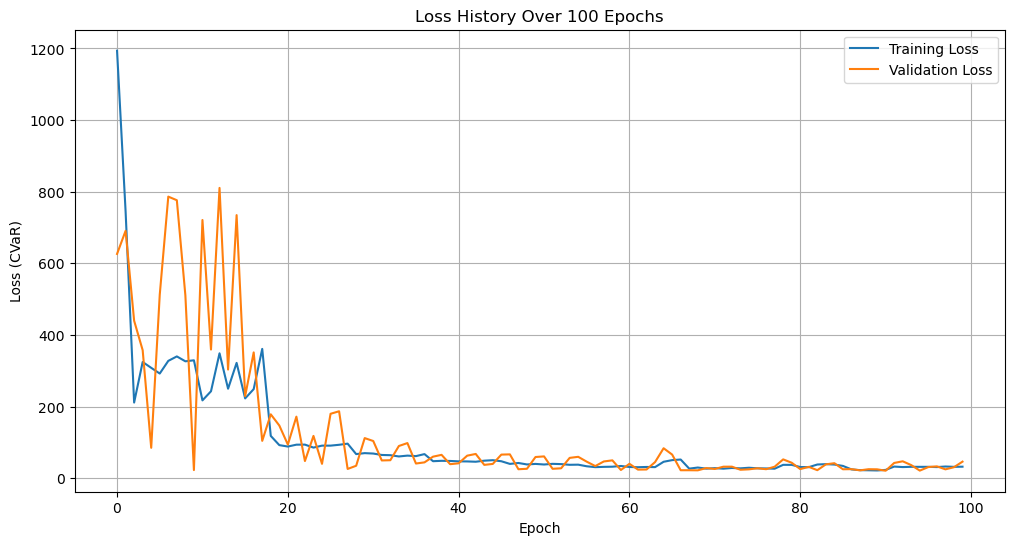

In [26]:
# Plot loss history
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss History Over 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (CVaR)')
plt.grid(True)
plt.legend()
plt.savefig('training_loss.png')
plt.show()



Starting comparison of different hedging strategies...

Evaluating Deep Hedging strategy:

Starting Deep Hedging Model evaluation...
Generating 500 paths with 30 steps for evaluation...
Running Deep Hedging Model on paths...
  Progress: 3.3% - Step 1/30, Time: 0.0s
  Progress: 23.3% - Step 7/30, Time: 0.0s
  Progress: 43.3% - Step 13/30, Time: 0.0s
  Progress: 63.3% - Step 19/30, Time: 0.1s
  Progress: 83.3% - Step 25/30, Time: 0.1s
  Progress: 100.0% - Step 30/30, Time: 0.1s
Deep Hedging evaluation completed in 0.10 seconds
Deep Hedging Evaluation Results:
Mean P&L: -10.5387
P&L Standard Deviation: 12.9504
VaR(95%): 33.1539
CVaR(95%): 40.2944
Average Trading Cost: 0.0019

Evaluating Heston Delta-Vega hedging strategy:

Starting Delta-Vega Hedging evaluation...
Generating price paths...
Starting hedging calculations for 500 paths over 30 steps...
Time step 1/30 - Remaining T: 1.0000
  Progress: 0.3% - Paths: 50/500 in step 1/30
  Elapsed time: 2.4s, Est. remaining: 712.3s
  Progress: 

/var/folders/v_/g8cn51c96_l31y5zbwlvt2j00000gp/T/ipykernel_21951/3846499699.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S[i, t] / params.K) + (params.r + 0.5 * current_vol**2) * remaining_T) / (current_vol * np.sqrt(remaining_T))


Time step 11/30 - Remaining T: 0.6667
Time step 12/30 - Remaining T: 0.6333
Time step 13/30 - Remaining T: 0.6000
Time step 14/30 - Remaining T: 0.5667
Time step 15/30 - Remaining T: 0.5333
Time step 16/30 - Remaining T: 0.5000
  Progress: 51.3% - Paths: 200/500 in step 16/30
  Elapsed time: 1.0s, Est. remaining: 0.9s
Time step 17/30 - Remaining T: 0.4667
Time step 18/30 - Remaining T: 0.4333
Time step 19/30 - Remaining T: 0.4000
Time step 20/30 - Remaining T: 0.3667
Time step 21/30 - Remaining T: 0.3333
Time step 22/30 - Remaining T: 0.3000
Time step 23/30 - Remaining T: 0.2667
Time step 24/30 - Remaining T: 0.2333
Time step 25/30 - Remaining T: 0.2000
Time step 26/30 - Remaining T: 0.1667
Time step 27/30 - Remaining T: 0.1333
Time step 28/30 - Remaining T: 0.1000
Time step 29/30 - Remaining T: 0.0667
Time step 30/30 - Remaining T: 0.0333

Black-Scholes Delta Hedging calculation complete in 1.85 seconds
Black-Scholes Delta Hedging Evaluation Results:
Mean P&L: -7.4601
P&L Standard Dev

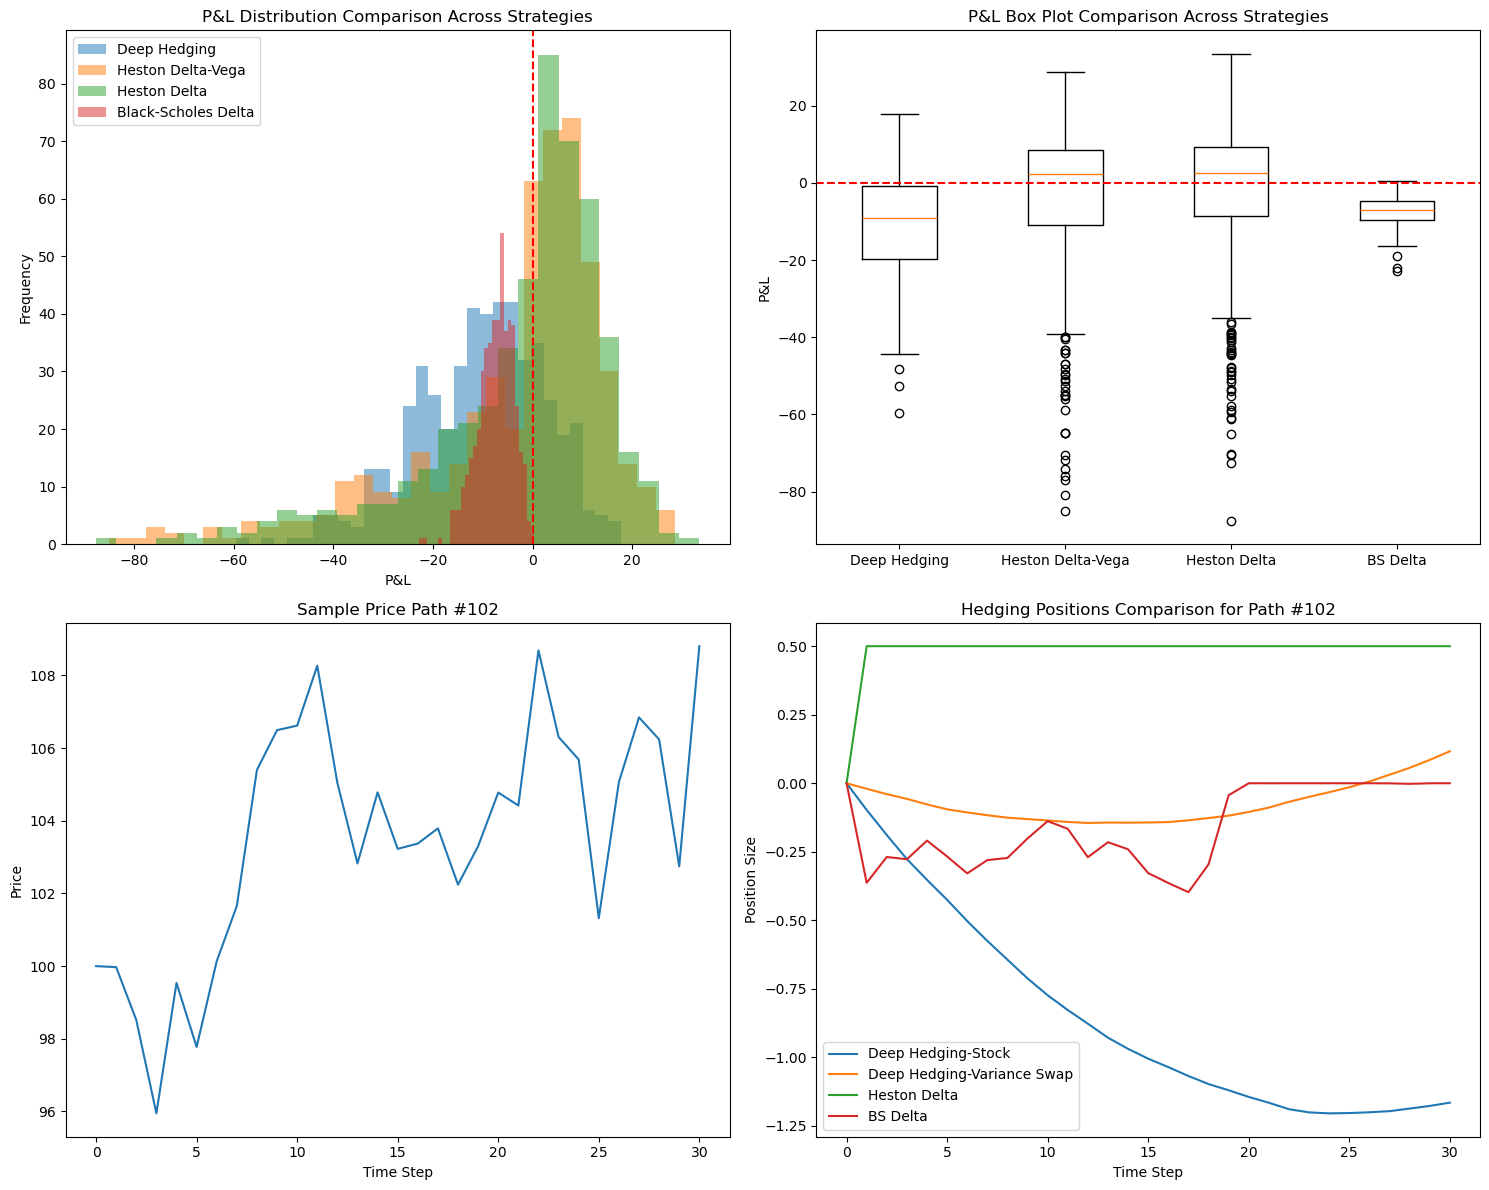


Numerical Performance Comparison Across Strategies:
       Strategy       Mean P&L        Std Dev       VaR(95%)      CVaR(95%)    Profit Prob
   Deep Hedging       -10.5387        12.9504        33.1539        40.2944         0.2240
Heston Delta-Vega        -3.5903        19.6725        44.2128        60.1842         0.5940
   Heston Delta        -2.3416        18.3543        43.3284        55.7177         0.6040
       BS Delta        -7.4601         3.6061        14.0229        16.0222         0.0020


In [27]:
# Compare different hedging strategies
deep_pnl, dv_pnl, d_pnl, bs_pnl, S, V, integrated_var = compare_hedging_strategies(
    params, model, n_paths=500, n_steps=n_steps
)



Creating advanced comparison plots...


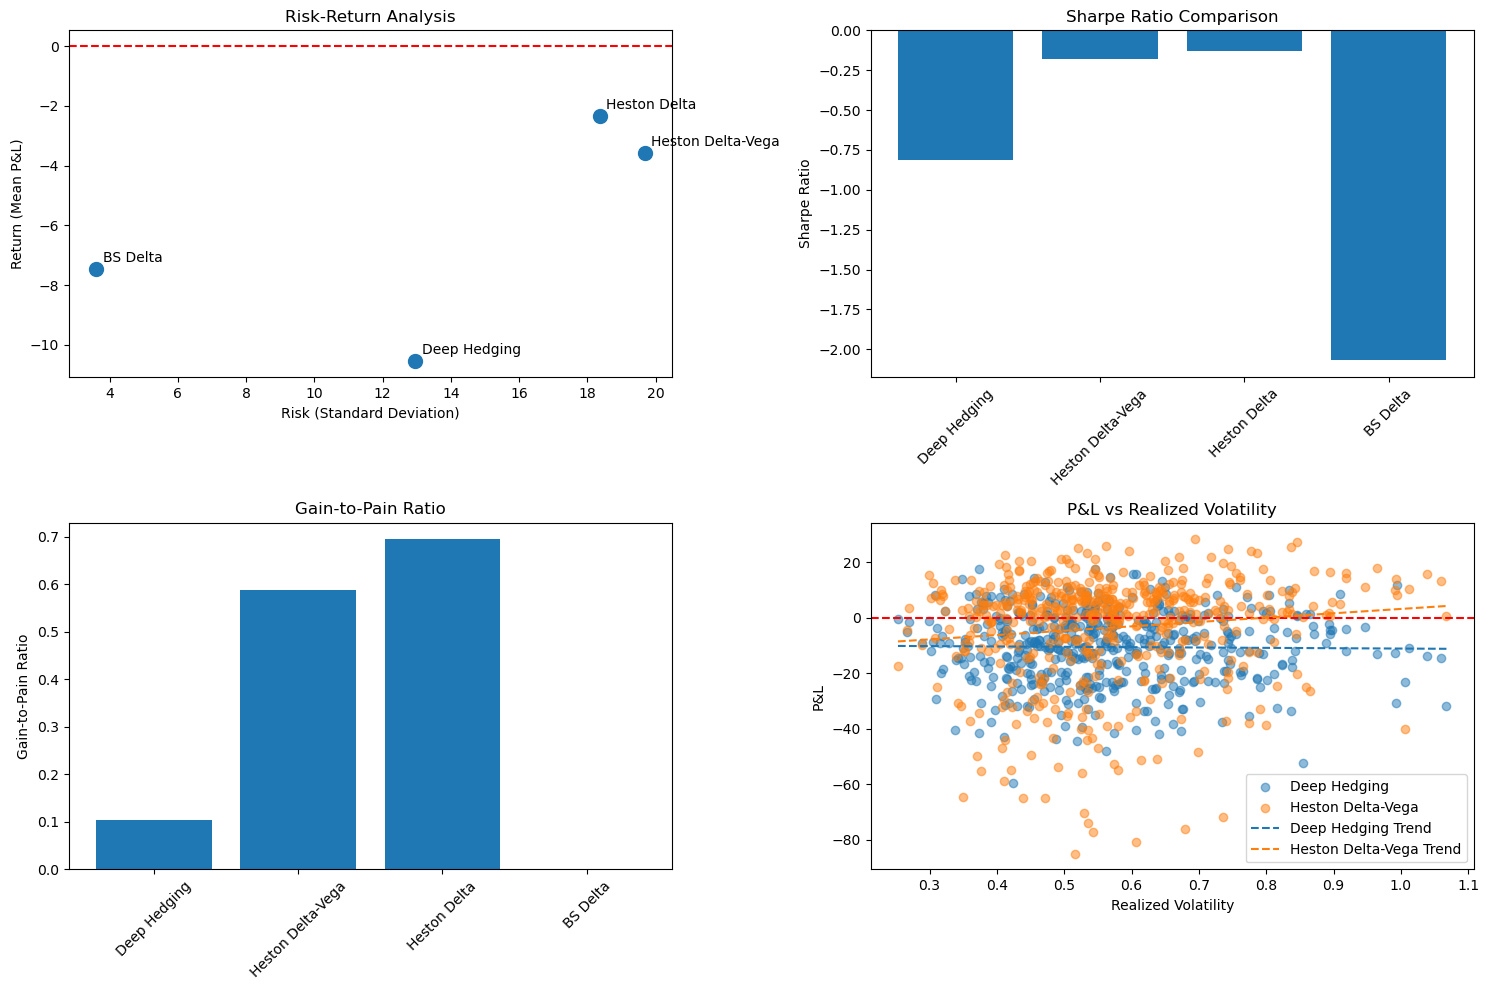

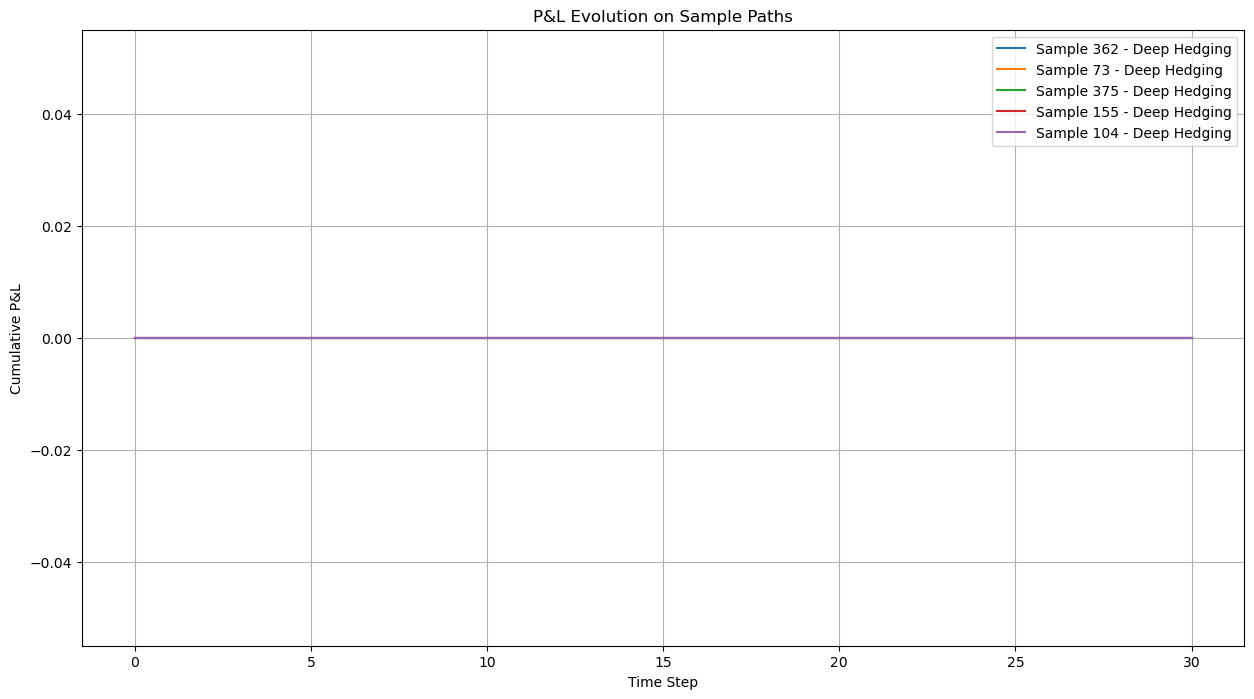

In [28]:
# Generate advanced comparison plots
create_advanced_comparison_plots(
    deep_pnl, dv_pnl, d_pnl, bs_pnl, 
    S, V, integrated_var
)


In [29]:
# Save model
# torch.save(model.state_dict(), 'deep_hedging_model_100epochs.pth')
# print("Model saved as 'deep_hedging_model_100epochs.pth'")




In [31]:
deep_pnl.shape

(500,)